In [1]:
using StateSpaceDynamics, Plots


In [2]:
model = initialize_slds()

SwitchingLinearDynamicalSystem([0.96 0.04; 0.04 0.96], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.001 0.0; 0.0 0.001]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([-0.39533949471978524 -0.86383255548

In [3]:
T = 1000
# Generate synthetic data
x, y, z = sample(model, T)


([0.012781148406102944 -0.043551433682513074 … 0.00918994518478555 0.032159415587346474; 0.03788281101630884 -0.021698572664429976 … -0.08498702535863967 -0.10696223889695364], [-0.0037362031674817928 0.011184638740456908 … -0.07094318488635357 -0.050323491624458885; 0.01979088919057409 0.030620168627788776 … 0.030785185388674228 0.0675583423786563; … ; -0.06176123606409473 0.086548578688241 … 0.137359927485125 0.03213684839745746; 0.042094688716242876 -0.10110240825174423 … -0.06636174473552493 -0.08508079724902803], [2, 2, 2, 2, 2, 2, 2, 2, 2, 2  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

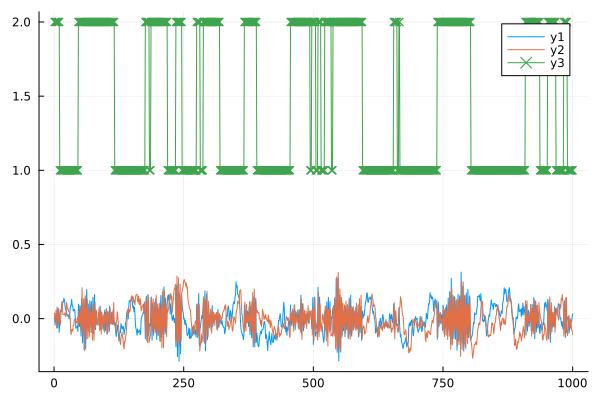

In [4]:
plot(x')
plot!(z, marker=:x)

In [5]:
using LinearAlgebra

p = model.B[1].obs_dim
d = model.B[1].latent_dim

K = model.K
A = [0.9 0.1; 0.2 0.8]
A ./= sum(A, dims=2) # Normalize rows to sum to 1

πₖ = rand(K)
πₖ ./= sum(πₖ) # Normalize to sum to 1

Q = Matrix(0.5 * I(d))

x0 = [0.0; 0.0]
P0 = Matrix(0.5 * I(d))

# set up the observation parameters
#C = randn(p, d)
#R = Matrix(0.5 * I(p))

C = model.B[1].obs_model.C
R = model.B[1].obs_model.R

# B = [StateSpaceDynamics.LinearDynamicalSystem(
#     StateSpaceDynamics.GaussianStateModel(0.95 * [cos(f) -sin(f); sin(f) cos(f)], Q, x0, P0),
#     StateSpaceDynamics.GaussianObservationModel(C, R),
#     d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

B = [StateSpaceDynamics.LinearDynamicalSystem(
   StateSpaceDynamics.GaussianStateModel(model.B[i].state_model.A, model.B[i].state_model.Q, x0, P0),
   StateSpaceDynamics.GaussianObservationModel(C, R),
   d, p, fill(true, 6  )) for (i,f) in zip(1:K, [0.5, 0.5])]

modeli = SwitchingLinearDynamicalSystem(A, B, πₖ, model.K)

SwitchingLinearDynamicalSystem([0.9 0.1; 0.2 0.8], StateSpaceDynamics.LinearDynamicalSystem[StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([0.9452539570141245 -0.09484174581448675; 0.09484174581448675 0.9452539570141245], [0.001 0.0; 0.0 0.001], [0.0, 0.0], [0.5 0.0; 0.0 0.5]), StateSpaceDynamics.GaussianObservationModel{Float64}([-0.31498797116895605 0.4338858743048611; -0.31125240132442067 -0.3954398407537453; … ; -0.8253345499750688 -0.9654904870197227; 0.840288523245819 0.9656607495563969], [0.001 0.0 … 0.0 0.0; 0.0 0.001 … 0.0 0.0; … ; 0.0 0.0 … 0.001 0.0; 0.0 0.0 … 0.0 0.001]), 2, 10, Bool[1, 1, 1, 1, 1, 1]), StateSpaceDynamics.LinearDynamicalSystem{StateSpaceDynamics.GaussianStateModel{Float64}, StateSpaceDynamics.GaussianObservationModel{Float64}}(StateSpaceDynamics.GaussianStateModel{Float64}([-0.39533949471978524 -0.8638325554843976; 0

In [6]:
model.A

2×2 Matrix{Float64}:
 0.96  0.04
 0.04  0.96

In [7]:
modeli.A

2×2 Matrix{Float64}:
 0.9  0.1
 0.2  0.8

In [8]:
K = modeli.K
T_step = size(y, 2)
FB = StateSpaceDynamics.initialize_forward_backward(modeli, T_step)
FS = [StateSpaceDynamics.initialize_FilterSmooth(model.B[k], T_step) for k in 1:K]
ml = zeros(10)

for i in 1:length(ml)
    ml[i] = variational_expectation!(modeli, y, FB, FS)   
end

In [9]:
ml

10-element Vector{Float64}:
 -89482.32098336998
  -6155.267895056316
  -5246.799025601681
  -5204.173592360128
  -5196.173040055496
  -5191.761924648827
  -5189.718092054028
  -5189.575079747965
  -5189.384152793673
  -5189.266109598892

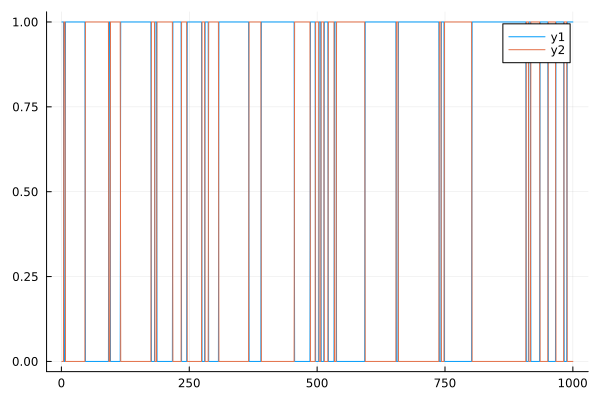

In [10]:
plot(exp.(FB.γ[1,:]))
plot!(exp.(FB.γ[2,:]))

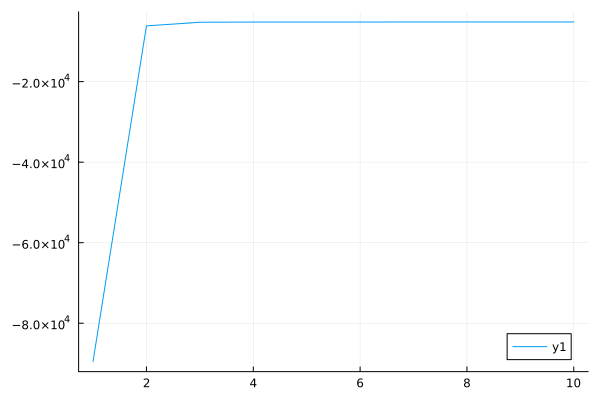

In [11]:
plot(ml)

In [12]:
mls, param_diff, FB, FS = fit!(modeli, y; max_iter=150)

Fitting SLDS via vEM... 100%|██████████████████████████████████████████████████| Time: 0:01:41 ( 0.68  s/it)


([-5189.266109598892, -5111.520325289004, -5108.011196167611, -5106.165678682347, -5105.164120787344, -5104.614030769892, -5104.312754173288, -5104.150391677711, -5104.066483523017, -5104.027583599253  …  -5105.840160750446, -5105.847419903021, -5105.8546089218835, -5105.861728480593, -5105.868779246501, -5105.875761881172, -5105.882677039573, -5105.889525370852, -5105.896307518362, -5105.903024118976], [0.9981842315461934, 0.014908921754377944, 0.006023063315634408, 0.0031155824406863836, 0.0021035975942228368, 0.0017349977610920516, 0.0016160394172072942, 0.0015730502182142586, 0.0015518975078704707, 0.0015366412785192316  …  0.0004653479054768119, 0.0004621723515683364, 0.0004590400394434483, 0.0004559504831879427, 0.00045290320159292524, 0.0004498977181093075, 0.0004469335607614266, 0.00044401026207895207, 0.00044112735903094563, 0.00043828439293900294], StateSpaceDynamics.ForwardBackward{Float64}([-4.610910765447468 -5.835678342297171 … -5.038107207612025 -8.349973097502154; -72.1

In [13]:
param_diff

150-element Vector{Float64}:
 0.9981842315461934
 0.014908921754377944
 0.006023063315634408
 0.0031155824406863836
 0.0021035975942228368
 0.0017349977610920516
 0.0016160394172072942
 0.0015730502182142586
 0.0015518975078704707
 0.0015366412785192316
 ⋮
 0.0004621723515683364
 0.0004590400394434483
 0.0004559504831879427
 0.00045290320159292524
 0.0004498977181093075
 0.0004469335607614266
 0.00044401026207895207
 0.00044112735903094563
 0.00043828439293900294

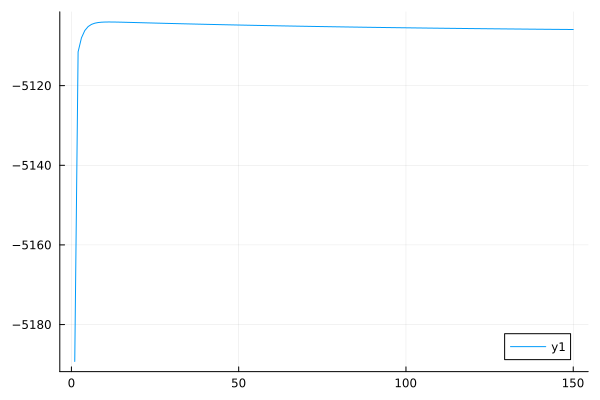

In [14]:
plot(mls)

In [15]:
diff(mls)

149-element Vector{Float64}:
 77.74578430988822
  3.5091291213930162
  1.8455174852642813
  1.001557895003316
  0.5500900174511116
  0.30127659660411155
  0.16236249557732663
  0.08390815469374502
  0.03889992376389273
  0.012881891550932778
  ⋮
 -0.007259152574988548
 -0.007189018862845842
 -0.007119558709746343
 -0.007050765907479217
 -0.006982634671658161
 -0.006915158400261134
 -0.006848331279798003
 -0.00678214750951156
 -0.006716600613799528

In [16]:
model.A

2×2 Matrix{Float64}:
 0.96  0.04
 0.04  0.96

In [17]:
1 .- eps()

0.9999999999999998

In [18]:
modeli.A

2×2 Matrix{Float64}:
 0.965742  0.0342578
 0.054404  0.945596

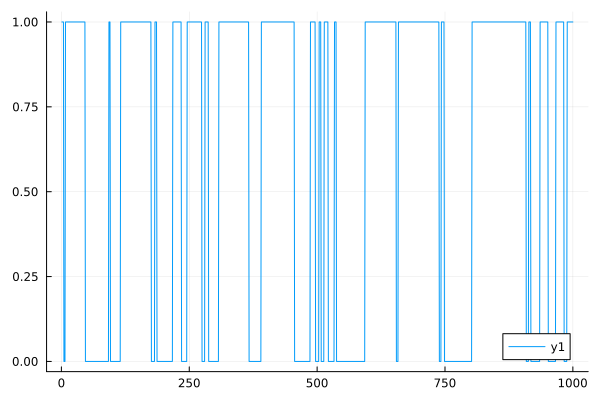

In [19]:
plot(exp.(FB.γ[1,:]))
#plot!(exp.(FB.γ[2,:]))

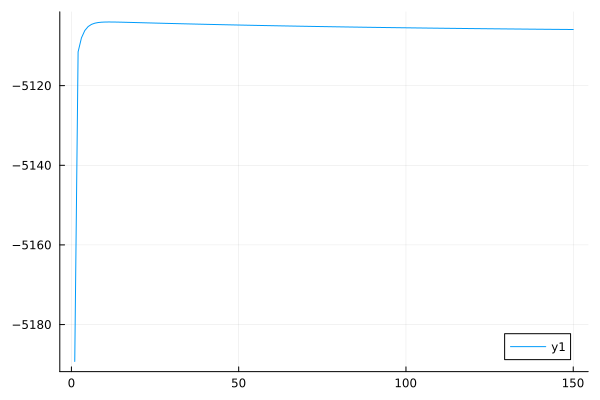

In [20]:
plot(mls)

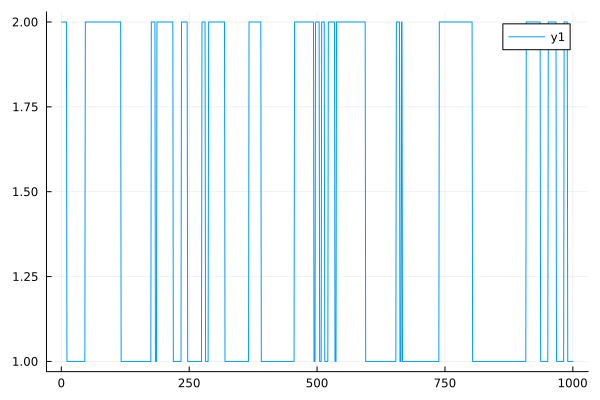

In [21]:
plot(z)

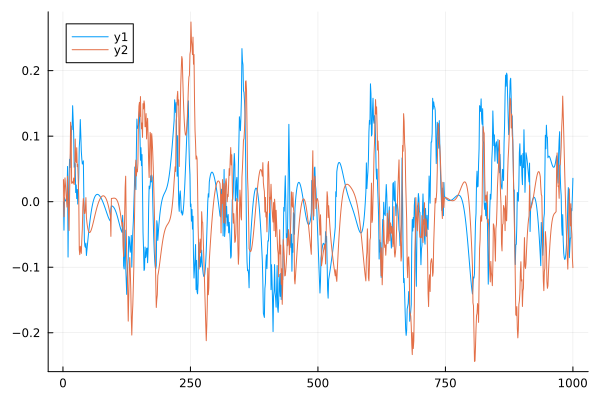

In [22]:
plot(FS[1].x_smooth')

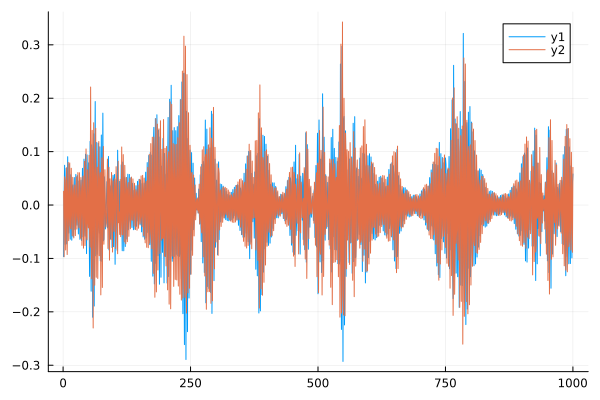

In [23]:
plot(FS[2].x_smooth')


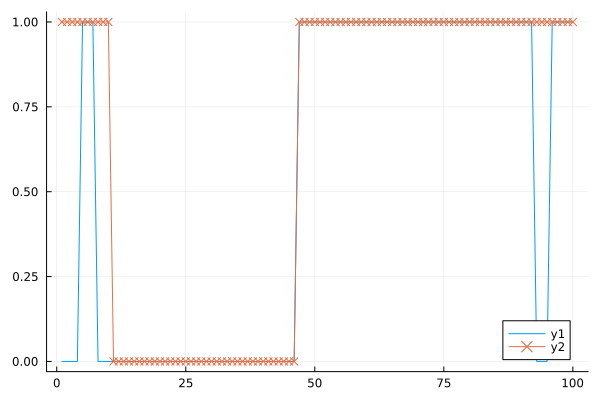

In [24]:
plot(exp.(FB.γ)'[1:100,2])
plot!(z[1:100] .- 1, marker=:x)

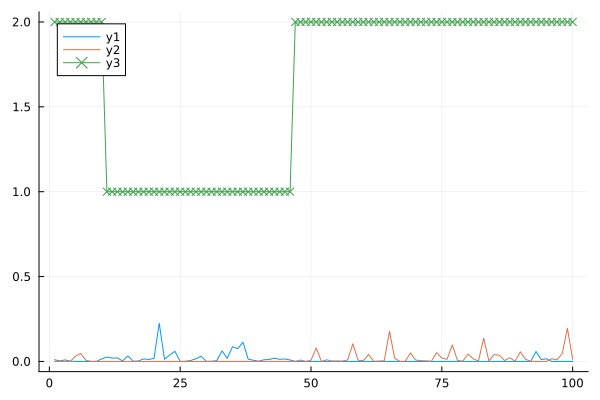

In [25]:
plot(exp.(FB.loglikelihoods[:,1:100])')
plot!(z[1:100], marker=:x)

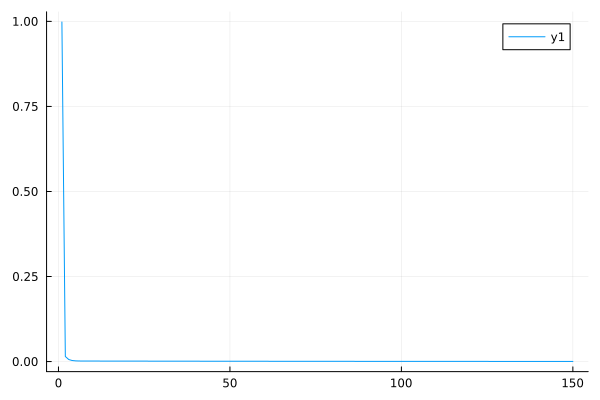

In [26]:
plot(param_diff)